In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils.class_weight import compute_class_weight

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import io
import random
import shutil
from PIL import Image


import time
from tqdm import tqdm

## Check how many class do we have

In [87]:
class_names = os.listdir("img_all_weight_15/")
class_names

['17_Soleirolia soleirolii',
 '20_Gerbera Daisy',
 '26_Nymphaea',
 '29_Iris  plant',
 '30_Lavandula plant',
 'Chinese Elm Bonsai',
 'Haworthiopsis fasciata',
 'Hypoestes phyllostachya',
 'Kalanchoe thyrsiflora',
 'Lithops']

In [ ]:
count = 0
count_gambar_foler = []
random.seed(42)
path = r"E:\jupyter\Bangkit\capstone project\img_"
for i in tqdm(os.listdir(path)):
    for img in os.listdir(os.path.join(path,i)):
        num = np.random.randint(10000)
        img_read = plt.imread(os.path.join(path,i,img))
        img_shape = img_read.shape
        if img_shape[2]!=3:
            print(os.path.join(path,i,img))
            print(img_read.shape)
            plt.imshow(img_read)
            plt.axis('off')
            plt.show()
            count+=1
            dest = os.path.join("prep_all_img_wrong_shape",f"{num}.jpg")
            #shutil.move(os.path.join(path,i,img),dest)
print(f"{count} images are wrong shapes")

## Extract Data

In [89]:
count = 0
count_gambar_foler = []
random.seed(42)
path = r"E:\jupyter\Bangkit\capstone project\img_all_weight_15"
for i in tqdm(os.listdir(path)):
    for img in os.listdir(os.path.join(path,i)):
        num = np.random.randint(10000)
        img_read = load_img(os.path.join(path,i,img))
        img_read = img_to_array(img_read)
        img_shape = img_read.shape
        if img_shape[2]!=3:
            print(os.path.join(path,i,img))
            print(img_read.shape)
            plt.imshow(img_read)
            plt.axis('off')
            plt.show()
            count+=1
            dest = os.path.join("prep_all_img_wrong_shape",f"{num}.jpg")
            #shutil.move(os.path.join(path,i,img),dest)
print(f"{count} images are wrong shapes")


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

0 images are wrong shapes


### Visualize the data

In [2]:
train_dir = r"E:\jupyter\Bangkit\capstone project\img_dir_all\train"
test_dir = r"E:\jupyter\Bangkit\capstone project\img_dir_all\test"

In [3]:
def view_random_image(target_dir,target_class):
    full_path_class = os.path.join(target_dir,target_class)
    plt.figure()
    for i in range(1,9):
        plt.subplot(3,3,i)
        pick_one_image = random.choice(os.listdir(full_path_class))

        full_path_image = os.path.join(full_path_class,pick_one_image)

        img = plt.imread(full_path_image)/255.
        print(f"Image shape: {img.shape}")
        plt.imshow(img)
        plt.axis("off")
        plt.show()
     
    
    
    

Image shape: (171, 295, 3)


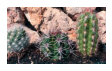

Image shape: (194, 259, 3)


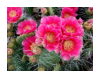

Image shape: (162, 310, 3)


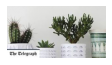

Image shape: (225, 225, 3)


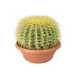

Image shape: (183, 275, 3)


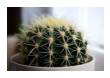

Image shape: (183, 275, 3)


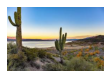

Image shape: (259, 194, 3)


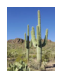

Image shape: (166, 303, 3)


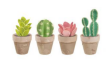

In [5]:
#train_dir
view_random_image(train_dir,"18_Cacti")

### Train Test Split Data

In [ ]:
import shutil
random.seed(42)
path = r"E:\jupyter\Bangkit\capstone project\img_all"
target = "img_prep_all"
for i in tqdm(os.listdir(path)):
    images_file = os.listdir(os.path.join(path,i))
    random.shuffle(images_file)

    for index,t in enumerate(images_file,start=1):
        original = os.path.join(path,i,t)
        if not os.path.exists(os.path.join(target,i)):
            os.mkdir(os.path.join(target,i))
        targets =os.path.join(target,i,t)
        shutil.copyfile(original, targets)
        if index==460:
            break

### Train Data Folder
* pick random image from img folder to img_dir, and put it into train folder

In [11]:
import shutil
path=r"E:\jupyter\Bangkit\capstone project\img_prep_all"
target="img_dir_all"
random.seed(42)
for i in tqdm(os.listdir(path)):
    images_file = os.listdir(os.path.join(path,i))
    random.shuffle(images_file)
    train_num = len(os.listdir(os.path.join(path,i)))-int(0.1*len(os.listdir(os.path.join(path,i))))
    for index,t in enumerate(images_file,start=1):
        original = os.path.join(path,i,t)
        if not os.path.exists(os.path.join(target,"train",i)):
            os.mkdir(os.path.join(target,"train",i))
        dest =os.path.join(target,"train",i,t)
        shutil.move(original, dest)
        if index== train_num:
            break

100%|██████████| 52/52 [00:04<00:00, 11.12it/s]


### Test Data Folder
* pick random image from img folder to img_dir, and put it into test folder

In [12]:
path=r"E:\jupyter\Bangkit\capstone project\img_prep_all"
target="img_dir_all"
for i in tqdm(os.listdir(path)):
    images_file = os.listdir(os.path.join(path,i))
    
    for index,t in enumerate(images_file,start=1):
        original = os.path.join(path,i,t)
        if not os.path.exists(os.path.join(target,"test",i)):
            os.mkdir(os.path.join(target,"test",i))
        dest =os.path.join(target,"test",i,t)
        
        shutil.move(original, dest)
       

100%|██████████| 52/52 [00:00<00:00, 84.55it/s]


### Setup data inputs

In [3]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    height_shift_range=0.2,
    width_shift_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

test_data = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False
)



Found 5710 images belonging to 10 classes.
Found 628 images belonging to 10 classes.


In [4]:
y_train=train_data.classes

In [5]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(y_train),
                                    y=y_train)
class_weight= 1/class_weight

weight = {i : class_weight[i] for i in range(10)}

### Create Model using MobileNetv2

In [6]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [60]:
tf.random.set_seed(42)
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable= False

inputs = layers.Input(shape=(224,224,3),name = "input_shape",dtype=tf.float16)
x = base_model(inputs,training=False)
x = layers.GlobalAvgPool2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(class_names),activation='softmax',dtype=tf.float32,name='outputs')(x)

model_2 = Model(inputs,outputs)

model_2.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 outputs (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [61]:
callback_model2 = ModelCheckpoint("checkpoint_all/model2_15Data_trad_classWeight_v2.h5")

In [62]:
history_model2 = model_2.fit(train_data,
                                 epochs=10,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 validation_steps=int(0.15 * len(test_data)), 
                                 callbacks=[callback_model2],
                            class_weight=weight)

Epoch 1/10
179/179 [==============================] - 50s 270ms/step - loss: 0.9237 - accuracy: 0.7163 - val_loss: 0.6760 - val_accuracy: 0.7917
Epoch 2/10
179/179 [==============================] - 48s 267ms/step - loss: 0.4779 - accuracy: 0.8573 - val_loss: 0.5196 - val_accuracy: 0.8333
Epoch 3/10
179/179 [==============================] - 48s 267ms/step - loss: 0.3860 - accuracy: 0.8884 - val_loss: 0.3730 - val_accuracy: 0.9062
Epoch 4/10
179/179 [==============================] - 48s 267ms/step - loss: 0.3354 - accuracy: 0.8963 - val_loss: 0.3683 - val_accuracy: 0.8854
Epoch 5/10
179/179 [==============================] - 48s 270ms/step - loss: 0.3045 - accuracy: 0.9067 - val_loss: 0.4016 - val_accuracy: 0.8750
Epoch 6/10
179/179 [==============================] - 48s 267ms/step - loss: 0.2806 - accuracy: 0.9182 - val_loss: 0.4277 - val_accuracy: 0.8750
Epoch 7/10
179/179 [==============================] - 48s 268ms/step - loss: 0.2463 - accuracy: 0.9301 - val_loss: 0.4685 - val_ac

In [63]:
model = load_model("checkpoint_all/model2_15Data_trad_classWeight.h5")

In [64]:
model.evaluate(test_data)

20/20 [==============================] - 2s 44ms/step - loss: 0.2689 - accuracy: 0.9204


[0.2688789367675781, 0.9203821420669556]

In [65]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [66]:
callback_model2_tuning = ModelCheckpoint("checkpoint_all/model2_tuning_15Data_classweight_trad",save_best_only=True)

In [67]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [68]:
fine_tune_epochs = 20

history_model2_tuning = model_2.fit(train_data,
                                     epochs=fine_tune_epochs,
                                     validation_data=test_data,
                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                     initial_epoch=history_model2.epoch[-1],
                                        callbacks=[callback_model2_tuning,reduce_lr],
                                   class_weight=weight) # 

Epoch 10/20
179/179 [==============================] - 64s 344ms/step - loss: 0.2835 - accuracy: 0.9070 - val_loss: 0.6232 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 11/20
179/179 [==============================] - 61s 337ms/step - loss: 0.2172 - accuracy: 0.9275 - val_loss: 0.2677 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 12/20
179/179 [==============================] - 48s 264ms/step - loss: 0.1737 - accuracy: 0.9454 - val_loss: 0.3641 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 13/20
179/179 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9450
Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
179/179 [==============================] - 48s 268ms/step - loss: 0.1653 - accuracy: 0.9450 - val_loss: 0.4418 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 14/20
179/179 [==============================] - 61s 342ms/step - loss: 0.0922 - accuracy: 0.9736 - val_loss: 0.2539 - val_accuracy: 0.9271 - lr: 2.0000e-05
Epoch 15/20
179/179 [=

## Evaluating Model

In [5]:
load_model_2_tuning = load_model("checkpoint_all/model2_tuning_15Data_classweight_trad")

In [10]:
load_model_2_tuning.evaluate(test_data)

20/20 [==============================] - 2s 52ms/step - loss: 0.1996 - accuracy: 0.9443


[0.19961543381214142, 0.9442675113677979]

In [12]:
from sklearn.metrics import classification_report

In [10]:
y_pred = load_model_2_tuning.predict(test_data).argmax(axis=1)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 5, 0, 0], dtype=int64)

In [13]:
print(classification_report(test_data.classes,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        56
           1       0.92      0.98      0.95        60
           2       0.93      1.00      0.96        76
           3       0.92      0.96      0.94        72
           4       0.92      0.92      0.92        73
           5       0.91      0.88      0.89        48
           6       0.96      0.94      0.95        47
           7       0.97      0.97      0.97        70
           8       0.98      0.95      0.97        65
           9       1.00      0.93      0.97        61

    accuracy                           0.94       628
   macro avg       0.95      0.94      0.94       628
weighted avg       0.95      0.94      0.94       628



In [37]:
path_pred = r"E:\jupyter\Bangkit\capstone project\img_dir_all\train\26_Nymphaea\img_9.jpg"

In [38]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [51]:
def img_prep_predict(path):
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    img=tf.expand_dims(img,axis=0)
    img = img/255.
    return img

In [83]:
img = img_prep_predict(path_pred)

In [93]:
load_model_2_tuning.predict(img).argmax(axis=1)

array([2], dtype=int64)

In [92]:
class_names[2]

'26_Nymphaea'